In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
model = gnn.GoldenGCN.load_from_checkpoint("models/golden_classifier/lightning_logs/version_0/checkpoints/epoch=20-step=7580.ckpt",dataset=None)

In [3]:
model.hparams

"batch_size":      1000
"edge_attr_names": ['dpt', 'dr', 'deta', 'dphi']
"loss":            std_loss
"lr":              0.001
"nn_conv1_out":    32
"nn_conv2_out":    128
"nn_edge_out":     64
"nn_node_out":     64
"node_attr_names": ['m', 'pt', 'eta', 'phi', 'btag']
"scale":           standardize

In [4]:
template = gnn.Dataset("data/template",make_template=True, transform=gnn.to_uptri_graph(), scale=model.hparams['scale'])

In [5]:
signaltree = Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1200_MY_500)
treeiter = ObjIter([signaltree])

In [6]:
treeiter.extend(kwargs=build_all_dijets)

[None]

In [7]:
from torch_geometric.loader import DataLoader

In [8]:
signaltree.graphs = DataLoader(gnn.Dataset(f'data/{signaltree.sample}-testing',transform=template.transform),batch_size=100,num_workers=8)

In [10]:
def predict_tree(tree):
    node_scores, edge_scores = [],[]
    for graph in tree.graphs:
        node_score, edge_score = model.predict(graph)
        node_scores.append(node_score)
        edge_scores.append(edge_score)
    node_scores = torch.cat(node_scores).cpu().numpy()
    edge_scores = torch.cat(edge_scores).cpu().numpy()
    
    node_scores = ak.unflatten(node_scores,ak.num(tree.jet_pt))
    edge_scores = ak.unflatten(edge_scores,ak.num(tree.dijet_pt))
    
    tree.extend(
        jet_score = node_scores,
        dijet_score = edge_scores
    )
    
    

In [11]:
treeiter.apply(predict_tree)


[None]

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='jet_score', ylabel='Fraction of Events'>,
        <AxesSubplot:xlabel='jet_score', ylabel='Fraction of Events'>],
       dtype=object))

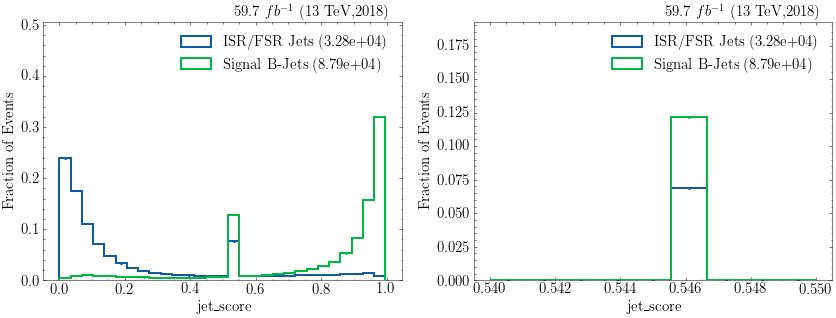

In [12]:
study.quick(
    treeiter+treeiter,
    masks=[signaltree.jet_signalId==-1,signaltree.jet_signalId>-1], 
    varlist=['jet_score','jet_score',],
    binlist=[None,np.linspace(0.54,0.55,10)],
    h_color=None,
    label=['ISR/FSR Jets','Signal B-Jets'],legend=1,
    density=1,
)

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='jet_score:0', ylabel='Fraction of Events'>,
        <AxesSubplot:xlabel='jet_signalId:0', ylabel='Fraction of Events'>],
       dtype=object))

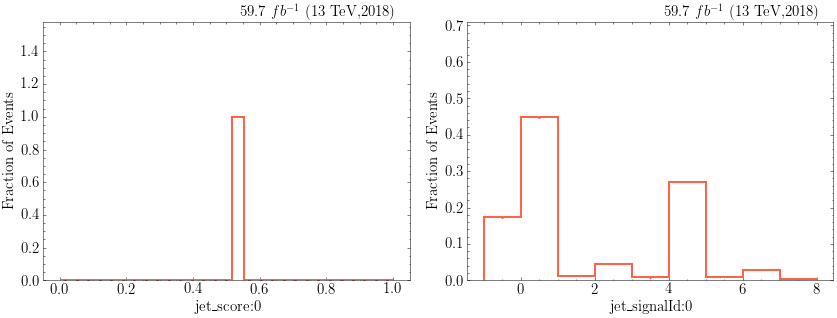

In [23]:
study.quick(
    treeiter,
    varlist=['jet_score:0','jet_signalId:0'],
    binlist=[np.linspace(0,1,30)],
    density=1,
)

(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:xlabel='dijet_score', ylabel='Fraction of Events'>)

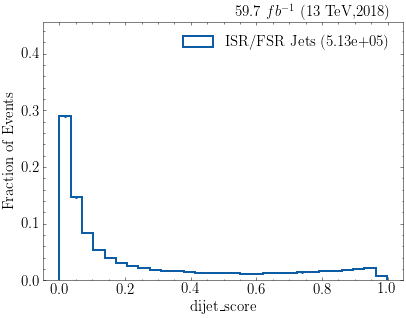

In [12]:
study.quick(
    treeiter,
    # masks=[signaltree.jet_signalId==-1,signaltree.jet_signalId>-1], 
    varlist=['dijet_score'],
    binlist=[None,np.linspace(0.54,0.55,10)],
    h_color=None,
    label=['ISR/FSR Jets','Signal B-Jets'],legend=1,
    density=1,
)

In [13]:
weird_score_spike_filter = lambda tree : np.abs(tree.jet_score - 0.546) < 1e-2

In [14]:
weirdtree= CollectionFilter('jet',filter=weird_score_spike_filter).filter(signaltree)
goodtree = CollectionFilter('jet',filter=lambda t :~weird_score_spike_filter(t)).filter(signaltree)

In [15]:
weirdtree.sample = 'weird score'
weirdtree.color = None

goodtree.sample = 'good score'
goodtree.color = None

treeiter = ObjIter([goodtree,weirdtree])

(<Figure size 1152x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Jet Pt (GeV)', ylabel='Fraction of Events'>,
         <AxesSubplot:xlabel='Jet Eta', ylabel='Fraction of Events'>,
         <AxesSubplot:xlabel='Jet Phi', ylabel='Fraction of Events'>],
        [<AxesSubplot:xlabel='Jet Mass', ylabel='Fraction of Events'>,
         <AxesSubplot:xlabel='Jet Btag', ylabel='Fraction of Events'>,
         <AxesSubplot:xlabel='jet_score', ylabel='Fraction of Events'>]],
       dtype=object))

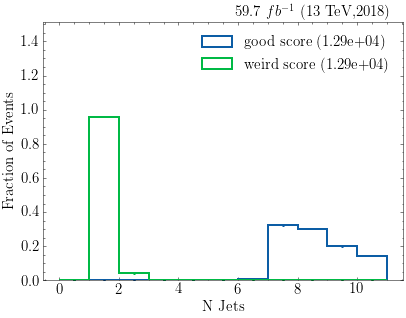

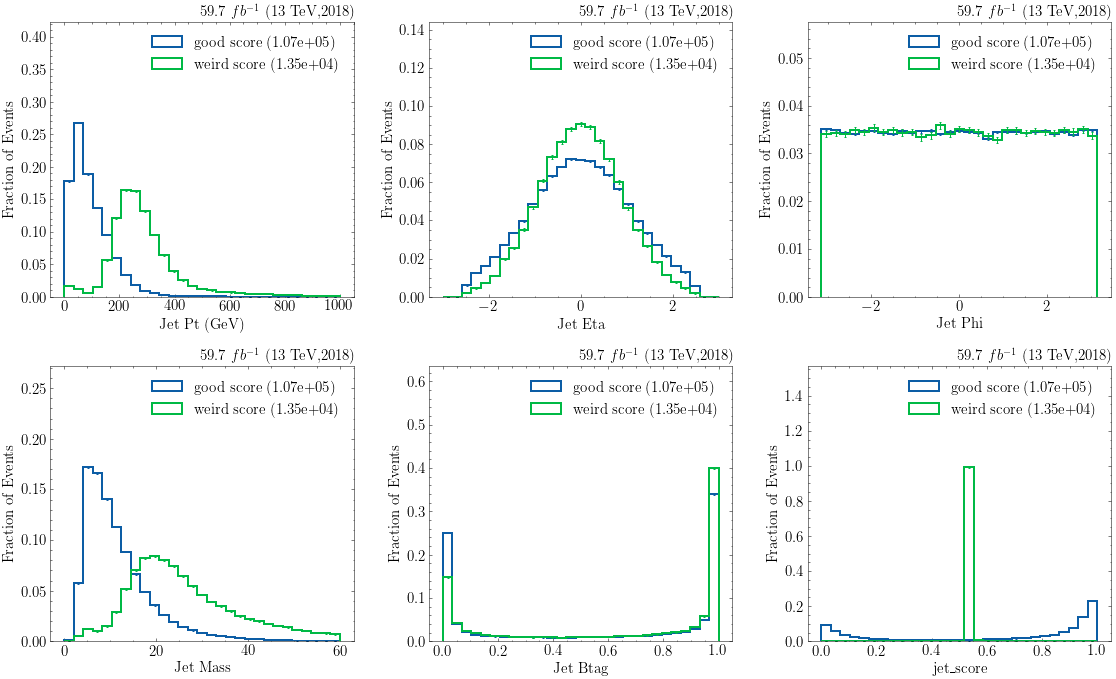

In [16]:
study.quick(
    treeiter,
    varlist=['n_jet'],
    # dim=(-1,3),
    density=1,
    legend=1,
)

study.quick(
    treeiter,
    varlist=['jet_pt','jet_eta','jet_phi','jet_m','jet_btag','jet_score'],
    dim=(-1,3),
    density=1,
    legend=1,
)

In [17]:
jets = get_collection(signaltree,'jet',False)

node_features = gnn.get_node_attrs(jets)
edge_features = gnn.get_edge_attrs(jets)

In [22]:
jet_id = ak.local_index(jets.pt,axis=-1)
edge_index_i = ak.flatten(jet_id[:,:,None]*ak.ones_like(jet_id[:,None]),axis=2)
edge_index_j = ak.flatten(ak.ones_like(jet_id[:,:,None])*jet_id[:,None],axis=2)
uptri_mask = edge_index_i < edge_index_j

In [23]:
scaled_node_features = template.node_scaler.transform(node_features)
scaled_edge_features = template.edge_scaler.transform(edge_features)[uptri_mask]


In [24]:
weird_node_mask = np.abs(jets.score-0.546)<1e-2
weird_edge_mask = ak.flatten(weird_node_mask[:,:,None] | weird_node_mask[:,None],axis=2)[uptri_mask]

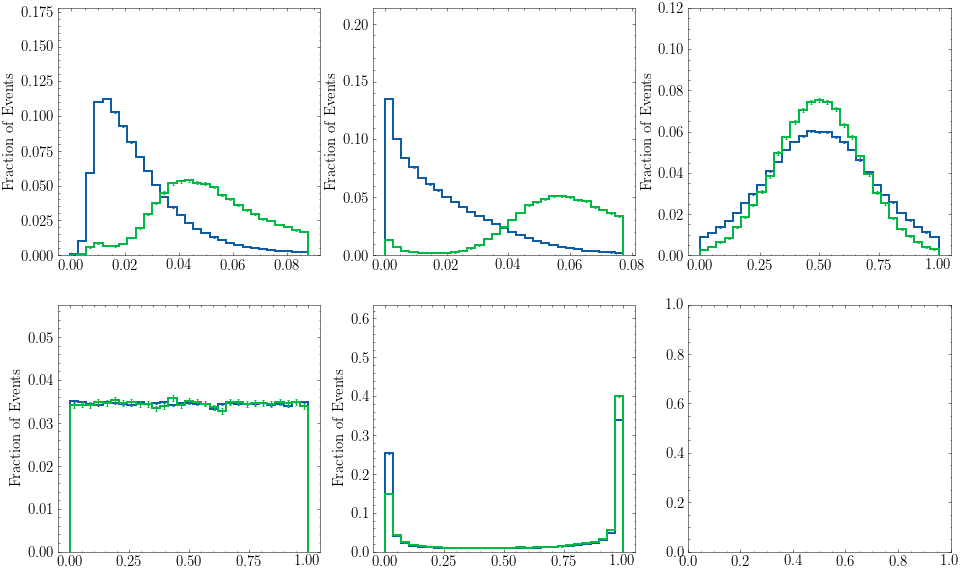

In [25]:
fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(16,10))

for i in range(5): 
    hist_multi(
        [scaled_node_features[~weird_node_mask][:,:,i],scaled_node_features[weird_node_mask][:,:,i]],
        density=True,
        figax=(fig,axs.flat[i])
    )

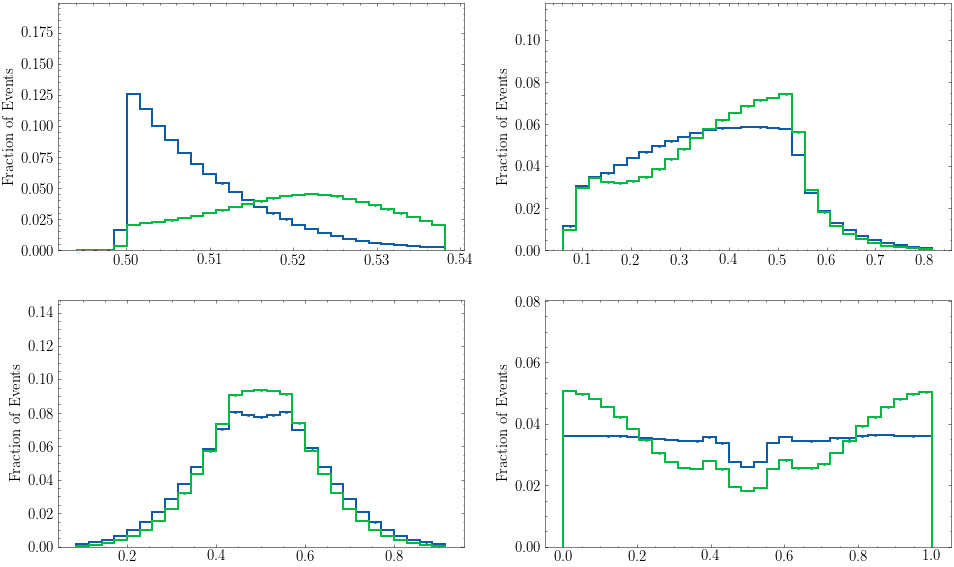

In [26]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(16,10))

for i in range(4): 
    hist_multi(
        [scaled_edge_features[~weird_edge_mask][:,:,i],scaled_edge_features[weird_edge_mask][:,:,i]],
        density=True,
        figax=(fig,axs.flat[i])
    )

In [27]:
dijets = get_collection(signaltree,'dijet',False)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

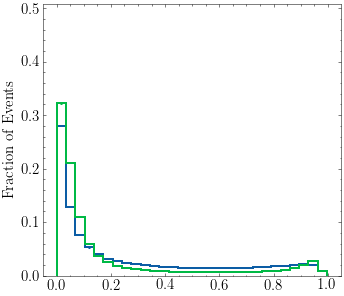

In [29]:
hist_multi(
        [dijets.score[~weird_edge_mask],dijets.score[weird_edge_mask]],
        density=True,
        # figax=(fig,axs.flat[i])
    )